![house](https://care4properties.co.uk/wp-content/uploads/2022/10/House-prices-October-2022.png)

# Import libraries

In [1]:
from sklearn.metrics import mean_squared_error
import category_encoders as ce

from lightgbm import LGBMRegressor

import pandas as pd
from scipy.stats import norm
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Review data

In [2]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv', index_col=0)

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# Visualization

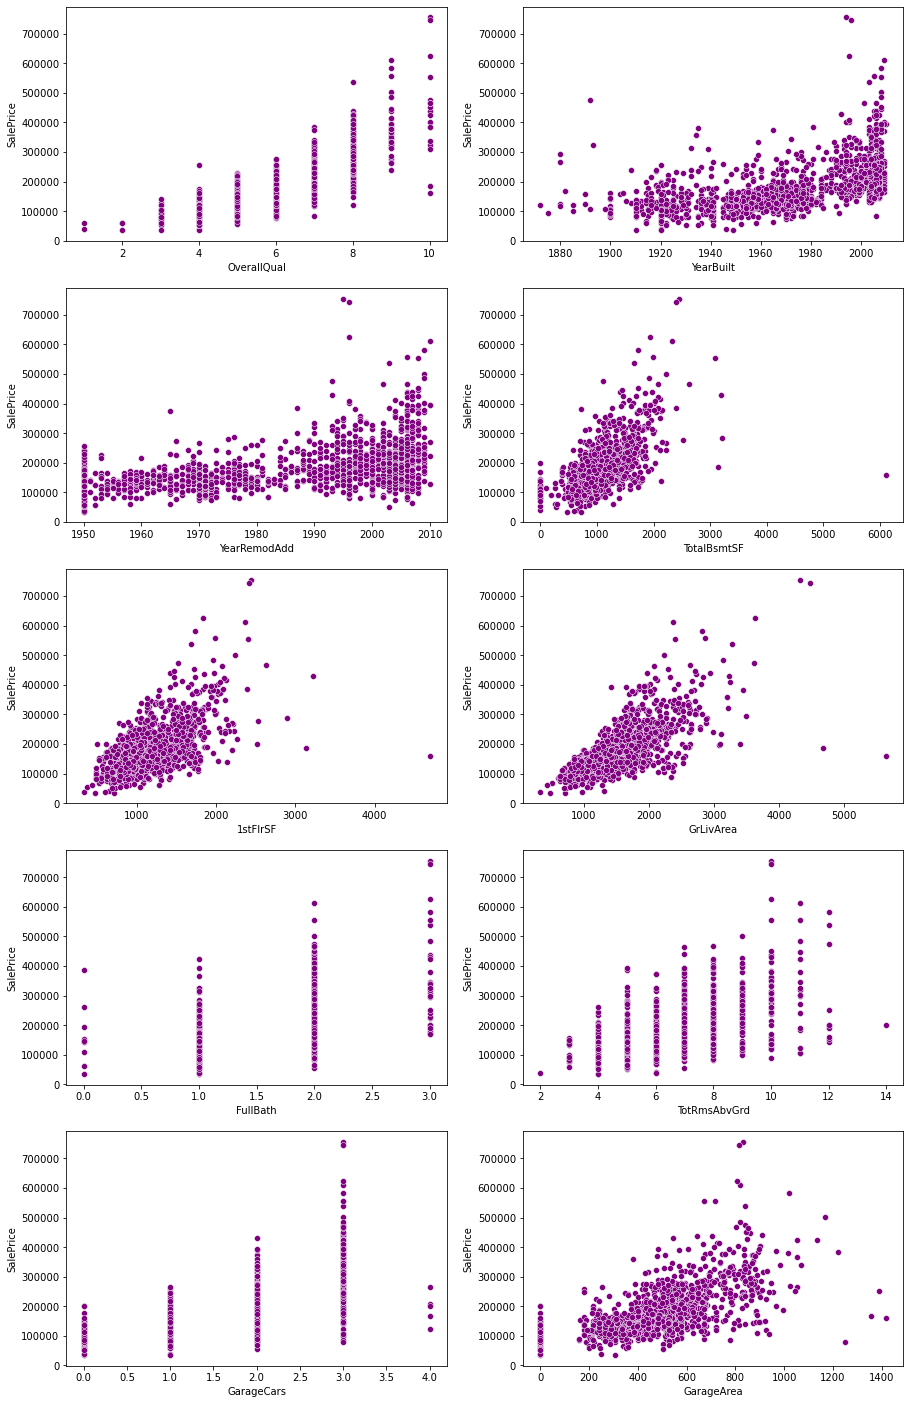

In [5]:
# correlation
cols = list(train.corrwith(train.SalePrice)[train.corrwith(train.SalePrice).abs()>0.5].index)
cols.remove('SalePrice')

fig, ax = plt.subplots(5, 2, figsize=(15, 25))

for i in range(5):
    for j in range(2):
        sns.scatterplot(ax=ax[i, j], x=train[cols[i*2+j]], y=train['SalePrice'], color='purple')

<AxesSubplot:>

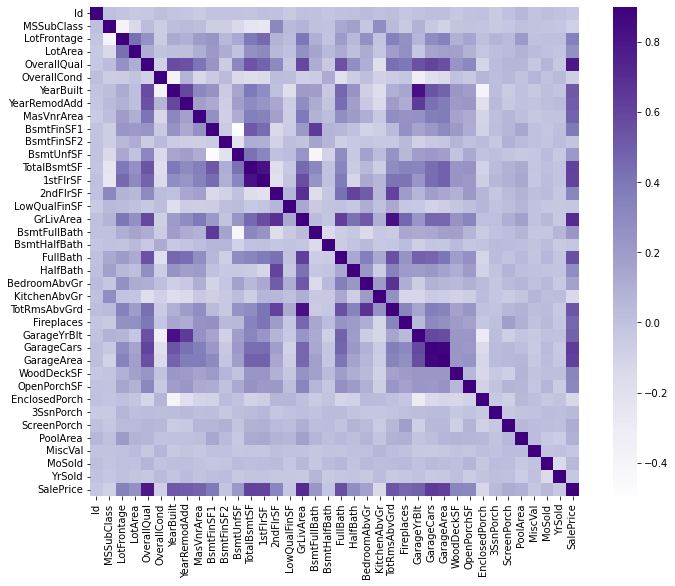

In [6]:
# correlation
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True, cmap='Purples')

In [7]:
# copy
trainc = train.copy()

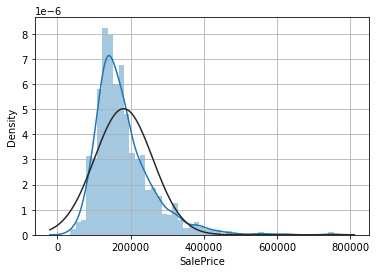

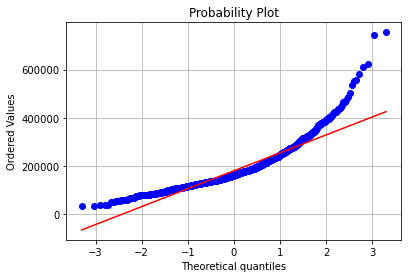

In [8]:
# histogram and normal probability plot
sns.distplot(trainc['SalePrice'], fit=norm)
plt.grid()
fig = plt.figure()
res = stats.probplot(trainc['SalePrice'], plot=plt)
plt.grid()

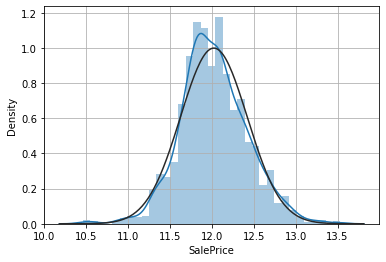

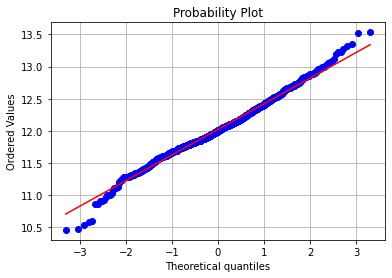

In [9]:
# applying log transformation
trainc['SalePrice'] = np.log(trainc['SalePrice'])

# transformed histogram and normal probability plot
sns.distplot(trainc['SalePrice'], fit=norm)
plt.grid()
fig = plt.figure()
res = stats.probplot(trainc['SalePrice'], plot=plt)
plt.grid()

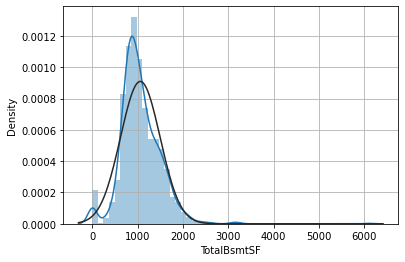

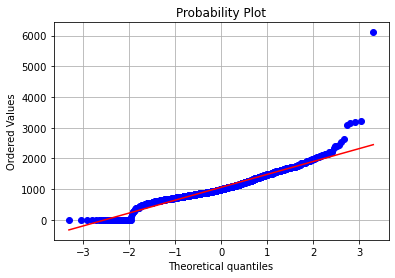

In [10]:
# histogram and normal probability plot
sns.distplot(trainc['TotalBsmtSF'], fit=norm)
plt.grid()
fig = plt.figure()
res = stats.probplot(trainc['TotalBsmtSF'], plot=plt)
plt.grid()

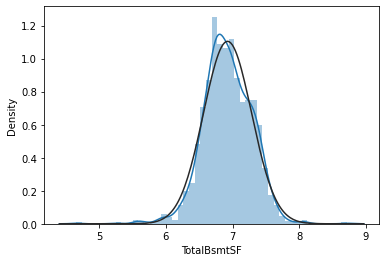

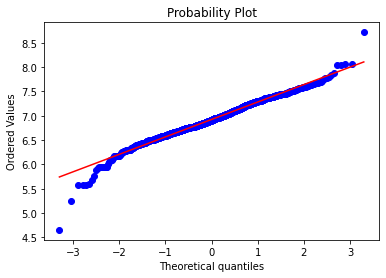

In [11]:
# applying log transformation
trainc['HasBsmt'] = pd.Series(len(trainc['TotalBsmtSF']), index=trainc.index)
trainc['HasBsmt'] = 0 
trainc.loc[trainc['TotalBsmtSF']>0,'HasBsmt'] = 1
trainc.loc[trainc['HasBsmt']==1,'TotalBsmtSF'] = np.log(trainc['TotalBsmtSF'])
# transformed histogram and normal probability plot
sns.distplot(trainc[trainc['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm)
fig = plt.figure()
res = stats.probplot(trainc[trainc['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

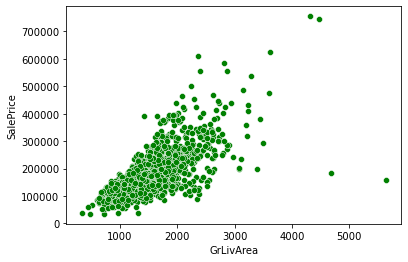

In [12]:
sns.scatterplot(x = train['GrLivArea'], y = train['SalePrice'], color='green')

# Processing

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

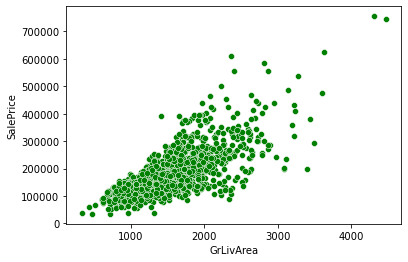

In [13]:
# Deleting outliers
train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index, inplace=True)
sns.scatterplot(x = train['GrLivArea'], y = train['SalePrice'], color='green')

In [14]:
# data aggregation
df = pd.concat([train.drop('SalePrice',1),test]).drop('Id',1).reset_index(drop=True)

In [15]:
# missing values
df.isna().sum()[df.isna().sum()>0].sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageCond       159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageArea         1
GarageCars         1
Electrical         1
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64

In [16]:
# fill nan values
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
for col in ('GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','MiscFeature','Alley','Fence','FireplaceQu','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType'):
    df[col] = df[col].fillna('None')
for col in ('GarageYrBlt','GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','MasVnrArea','MSZoning','SaleType','Exterior1st','Exterior2nd','KitchenQual','Electrical'):
    df[col] = df[col].fillna(0)
df["Functional"] = df["Functional"].fillna("Typ")
df = df.drop(['Utilities'], axis=1)

In [17]:
# Log-transformation of the target variable
train['SalePrice'] = np.log(train['SalePrice'])

for i in ['GrLivArea', '1stFlrSF', 'LotArea']:
    df[i] = np.log(df[i])

df['HasBsmt'] = 0
df.loc[df['TotalBsmtSF']>0,'HasBsmt'] = 1
df.loc[df['HasBsmt']==1,'TotalBsmtSF'] = np.log(df['TotalBsmtSF'])

In [18]:
# split
y = train.SalePrice.reset_index(drop=True)

n = train.shape[0]
train = df[:n]
test = df[n:]

X = train.copy()

In [19]:
# encode object columns
obj_col = list(X.columns[X.dtypes=='object'])

target_encoder = ce.TargetEncoder()

X[obj_col] = target_encoder.fit_transform(X[obj_col], y)
test[obj_col] = target_encoder.transform(test[obj_col])

# Train model

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [21]:
# LGBMRegressor model
model = LGBMRegressor()
model.fit(X_train, y_train, eval_set = (X_test, y_test), early_stopping_rounds = 5)

[1]	valid_0's l2: 0.119936
[2]	valid_0's l2: 0.100919
[3]	valid_0's l2: 0.0836652
[4]	valid_0's l2: 0.0705527
[5]	valid_0's l2: 0.059403
[6]	valid_0's l2: 0.0502263
[7]	valid_0's l2: 0.0432646
[8]	valid_0's l2: 0.036454
[9]	valid_0's l2: 0.0317821
[10]	valid_0's l2: 0.0278248
[11]	valid_0's l2: 0.0242914
[12]	valid_0's l2: 0.021974
[13]	valid_0's l2: 0.0197465
[14]	valid_0's l2: 0.0177173
[15]	valid_0's l2: 0.016399
[16]	valid_0's l2: 0.0149799
[17]	valid_0's l2: 0.0135144
[18]	valid_0's l2: 0.0124455
[19]	valid_0's l2: 0.0118076
[20]	valid_0's l2: 0.0112679
[21]	valid_0's l2: 0.0108129
[22]	valid_0's l2: 0.010546
[23]	valid_0's l2: 0.0101347
[24]	valid_0's l2: 0.00994744
[25]	valid_0's l2: 0.00978332
[26]	valid_0's l2: 0.00957555
[27]	valid_0's l2: 0.00940727
[28]	valid_0's l2: 0.00929122
[29]	valid_0's l2: 0.00919254
[30]	valid_0's l2: 0.00906428
[31]	valid_0's l2: 0.00893445
[32]	valid_0's l2: 0.00899565
[33]	valid_0's l2: 0.00890065
[34]	valid_0's l2: 0.00886703
[35]	valid_0's l2: 

LGBMRegressor()

In [22]:
# evaluation
train_pred = model.predict(X_test)
print("MSE:",np.sqrt(mean_squared_error(y_test, train_pred)))

MSE: 0.09263676897730524


# Submission

In [23]:
submission.SalePrice = np.exp(model.predict(test))
submission.to_csv('submission.csv')
pd.read_csv('submission.csv', index_col=0)

,SalePrice
Id,
1461,124793.955786
1462,163950.959861
1463,187547.140084
1464,183015.525668
1465,199648.320581
...,...
2915,79811.578698
2916,81649.679612
2917,152297.391281
